# HMMER Tutorial - Exploring the Data

The HMMER tutorial should be completed or a copy of the data downloaded ([figshare](http://files.figshare.com/2599149/tutorial_hmmer_data.zip)) and uncompressed. The followind variable can be used to change the default location.

In [1]:
# Directory where the tutorial data is found
data_dir = 'tutorial-hmmer-data/'

## Imports

In [2]:
from __future__ import print_function

#Python Standard Library
import glob
import pickle
import sys
import itertools

#External Dependencies (install via pip or anaconda)

# Check if running interactively or not
import matplotlib as mpl # http://matplotlib.org
# from:
# http://stackoverflow.com/questions/15411967/how-can-i-check-if-code-is-executed-in-the-ipython-notebook
# and
# http://stackoverflow.com/questions/15455029/python-matplotlib-agg-vs-interactive-plotting-and-tight-layout
import __main__ as main
if hasattr(main, '__file__'):
    # Non interactive, force the use of Agg backend instead
    # of the default one
    mpl.use('Agg')

import numpy # http://www.numpy.org
import pandas # http://pandas.pydata.org
import seaborn # http://stanford.edu/~mwaskom/software/seaborn/
import scipy # http://www.scipy.org
import matplotlib.pyplot as plt 


#MGKit Import
from mgkit.io import gff, fasta
from mgkit.mappings import eggnog
import mgkit.counts, mgkit.taxon, mgkit.snps, mgkit.plots
import mgkit.snps
import mgkit.mappings.enzyme
import mgkit.net.uniprot
import mgkit.utils.dictionary
import mgkit.kegg

/Users/francesco/dev/dev-env/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
mgkit.logger.config_log()

In [4]:
mgkit.cite(sys.stdout)


 _|      _|    _|_|_|  _|    _|  _|    _|
 _|_|  _|_|  _|        _|  _|        _|_|_|_|
 _|  _|  _|  _|  _|_|  _|_|      _|    _|
 _|      _|  _|    _|  _|  _|    _|    _|
 _|      _|    _|_|_|  _|    _|  _|      _|_|


MGKit Version: 0.2.1

Rubino, F. and Creevey, C.J. (2014).
MGkit: Metagenomic Framework For The Study Of Microbial Communities.

Available at: http://figshare.com/articles/MGkit_Metagenomic_Framework_For_The_Study_Of_Microbial_Communities/1269288

[doi:10.6084/m9.figshare.1269288]



## Reads Data

In [5]:
# This file contains the SNPs information and it is the output
# of the snp_parser script
snp_data = pickle.load(open('{}snp_data.pickle'.format(data_dir), 'r'))

In [6]:
# Taxonomy needs to be download beforehand. It is loaded into an an
# instance of mgkit.taxon.UniprotTaxonomy. It is used in filtering
# data and to map taxon IDs to different levels in the taxonomy
taxonomy = mgkit.taxon.UniprotTaxonomy('{}mg_data/taxonomy.pickle'.format(data_dir))

INFO:mgkit.taxon:Loading taxonomy from file tutorial-hmmer-data/mg_data/taxonomy.pickle
2015-12-04 14:08:38,059 -    INFO - mgkit.taxon->load_data: Loading taxonomy from file tutorial-hmmer-data/mg_data/taxonomy.pickle


In [7]:
# Loads all annotations in a dictionary, with the unique ID (uid) as key
# and the mgkit.io.gff.Annotation instance that represent the line in the
# GFF file as value
annotations = {x.uid: x for x in gff.parse_gff('{}assembly.filt.cov.gff'.format(data_dir))}

INFO:mgkit.io.gff:Loading GFF from file (tutorial-hmmer-data/assembly.filt.cov.gff)
2015-12-04 14:10:30,369 -    INFO - mgkit.io.gff->parse_gff: Loading GFF from file (tutorial-hmmer-data/assembly.filt.cov.gff)


In [8]:
# Sample names
sample_names = {
    'I': "Influent",
    'B': "Buffering",
    'SA': "Secondary aeration",
    'PA': "Primary aeration",
    'SD': "Sludge digestion",
}

## Explore Taxa Diversity

Diversity in metagenomic samples can be analysed using pN/pS values. The data required to do this was produced in the tutorial by the *snp_parser* script. Here are some examples of how to calculate diversity estimates from this data.

The complete toolset to map diversity estimates can be found in the **mgkit.snps** package, with the *mgkit.snps.funcs.combine_sample_snps* function building the final pandas DataFrame. As the use of the function requires the initialisation of different functions, a few easier to use ones are available in the **mgkit.snps.conv_func** module:

* get_rank_dataframe
* get_gene_map_dataframe
* get_full_dataframe
* get_gene_taxon_dataframe

The first is used to get diversity estimates for taxa, the second for genes/functions. The other two provides functionality to return estimates tied to both taxon and function.

In [9]:
# Sets the minimum coverage for an annotation to be
# included into the table (defaults to 4)
mgkit.consts.DEFAULT_SNP_FILTER['min_cov'] = 4

In [10]:
# To get diversity estimates for taxa *mgkit.snps.conv_func.get_rank_dataframe* can be used
# It is also imported and accesible from the *mgkit.snps* package
# ATTENTION: the lowest rank that can be used is *order*, since that's the level that was
# used when the profiles were created
pnps = mgkit.snps.get_rank_dataframe(snp_data, taxonomy, min_num=3, rank='order', index_type='taxon')

INFO:mgkit.snps.funcs:Analysing SNP from sample I
2015-12-04 14:10:30,781 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample I
INFO:mgkit.snps.funcs:Analysing SNP from sample SA
2015-12-04 14:10:31,072 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SA
INFO:mgkit.snps.funcs:Analysing SNP from sample B
2015-12-04 14:10:31,168 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample B
INFO:mgkit.snps.funcs:Analysing SNP from sample PA
2015-12-04 14:10:31,393 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample PA
INFO:mgkit.snps.funcs:Analysing SNP from sample SD
2015-12-04 14:10:31,662 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SD


In [11]:
# Renaming the columns and rows
pnps = pnps.rename(
    columns=sample_names,
    index=lambda x: taxonomy[x].s_name.capitalize()
)

In [12]:
# The dataframe exposes a method that print a table with some basic statistics
pnps.describe()

,Buffering,Influent,Primary aeration,Secondary aeration,Sludge digestion
count,60.000000,55.000000,60.000000,53.000000,48.000000
mean,0.439053,0.368924,0.434174,0.300415,0.277117
std,0.421404,0.421266,0.348828,0.340843,0.463352
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.120212,0.000000,0.156754,0.000000,0.000000
50%,0.377335,0.167667,0.389669,0.200464,0.096411
75%,0.652356,0.588091,0.703563,0.509091,0.340973
max,2.168022,1.481172,1.448138,1.447522,2.130008


In [13]:
# The complete table
pnps

,Buffering,Influent,Primary aeration,Secondary aeration,Sludge digestion
Coriobacteriales,0.000000,0.000000,NaN,0.000000,0.000000
Sphaerobacterales,0.000000,0.040271,0.000000,NaN,NaN
Bifidobacteriales,0.000000,0.000000,0.000000,0.000000,0.000000
Micrococcales,0.325792,NaN,0.216755,0.213321,0.310000
Corynebacteriales,0.779613,0.598788,0.813224,0.614930,0.436968
Pseudonocardiales,0.491324,0.000000,0.590002,0.487183,NaN
Streptomycetales,0.490956,1.022727,0.437736,0.622101,0.592287
Frankiales,NaN,0.000000,0.000000,0.000000,0.000000
Myxococcales,0.249625,NaN,0.185956,0.698357,0.338927
Synergistales,NaN,0.000000,NaN,0.000000,0.000000


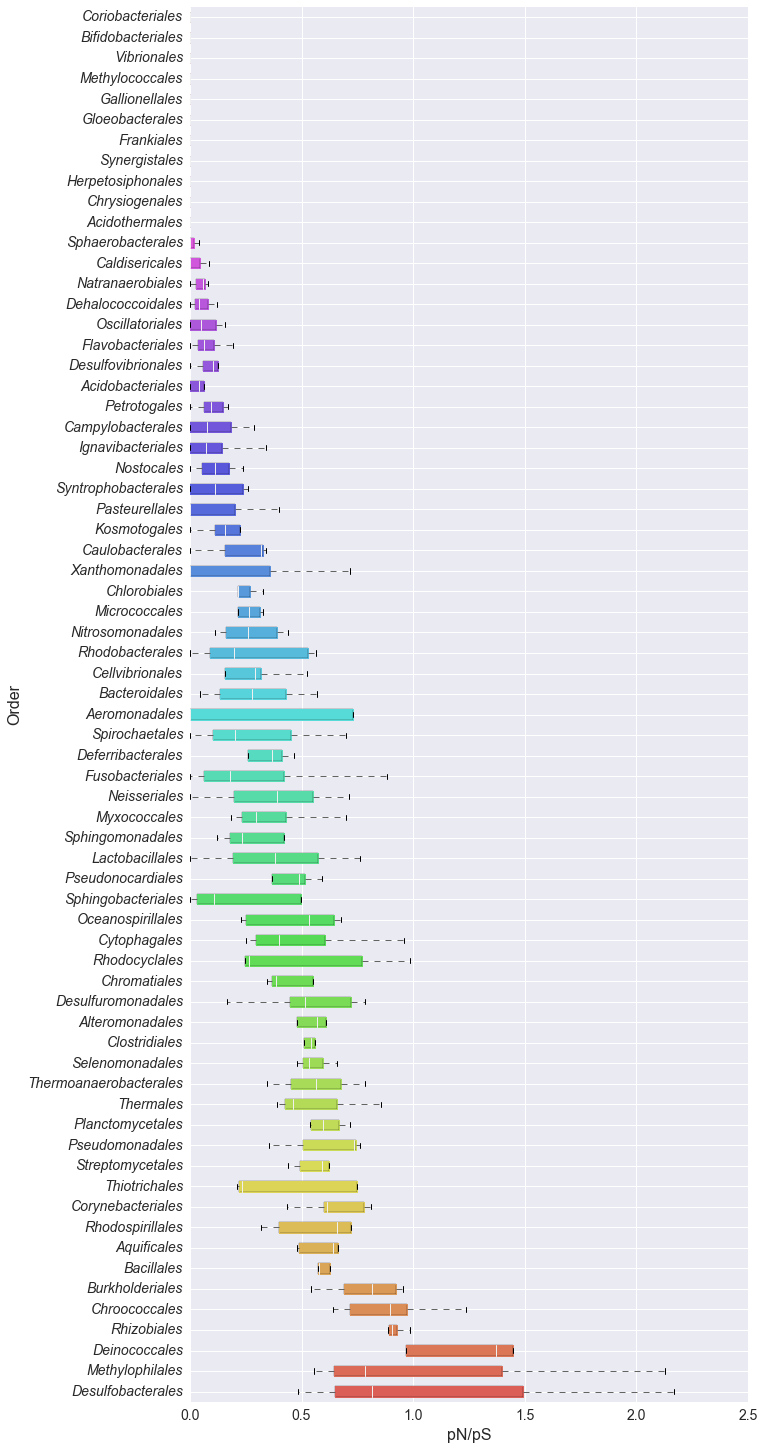

In [14]:
# sort the DataFrame to plot them by mean value
# older versions of pandas have a *sort* method instead of a *sort_values*
plot_order = pnps.mean(axis=1).sort_values(inplace=False, ascending=False).index

# A matplotlib single figure (sizes are in inches) can be created via a function in mgkit
fig, ax = mgkit.plots.get_single_figure(figsize=(10, 25))

# This function uses the boxplot function in matplotlib, adding some easier to use functionality
_ = mgkit.plots.boxplot.boxplot_dataframe(
    pnps,
    plot_order, 
    ax,
    # By default the function renders the boxplot vertical.
    box_vert=False,
    # some fonts settings, note the *rotation* key, it refers to the rotation of the 
    # labels for the taxa names. The default is vertical, as the boxplot order above
    fonts=dict(fontsize=14, rotation='horizontal'),
    # the colours are generated with hls color palette, for the number of rows in the
    # DataFrame
    data_colours={
        x: color
        for x, color in zip(plot_order, seaborn.color_palette('hls', len(pnps.index)))
    }
)

# Taxa names should be in italics
for text in ax.get_yticklabels():
    text.set_fontstyle('italic')

# It sets the axes labels
_ = ax.set_xlabel('pN/pS', fontsize=16)
_ = ax.set_ylabel('Order', fontsize=16)

### Phylum Level Diversity

Even if it was chosen the *Order* as rank for the profiles, a higher level represantation can be obtained.

INFO:mgkit.snps.funcs:Analysing SNP from sample I
2015-12-04 14:10:33,608 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample I
INFO:mgkit.snps.funcs:Analysing SNP from sample SA
2015-12-04 14:10:34,748 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SA
INFO:mgkit.snps.funcs:Analysing SNP from sample B
2015-12-04 14:10:35,199 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample B
INFO:mgkit.snps.funcs:Analysing SNP from sample PA
2015-12-04 14:10:36,434 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample PA
INFO:mgkit.snps.funcs:Analysing SNP from sample SD
2015-12-04 14:10:38,027 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SD


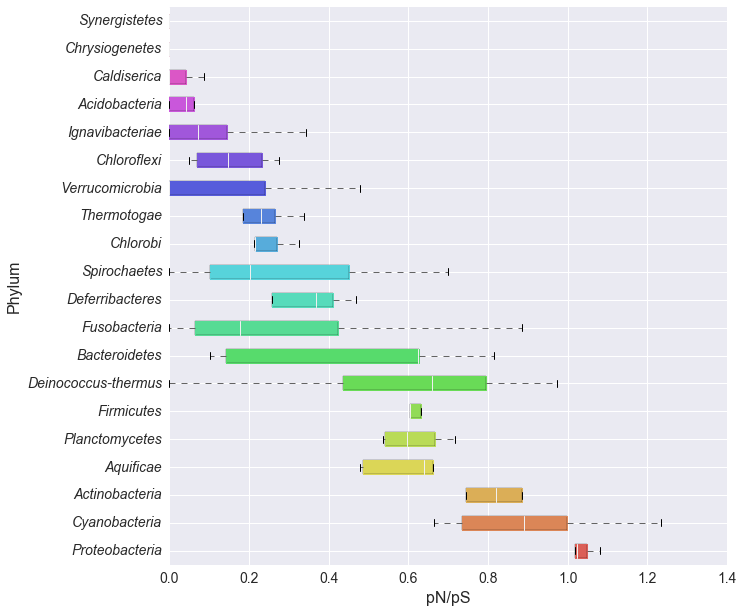

In [15]:
# The only difference is the *rank* chosen and the size of the plot
pnps = mgkit.snps.get_rank_dataframe(snp_data, taxonomy, min_num=3, rank='phylum', index_type='taxon')

pnps = pnps.rename(
    columns=sample_names,
    index=lambda x: taxonomy[x].s_name.capitalize()
)
#sort the DataFrame to plot them by mean value
plot_order = pnps.mean(axis=1).sort_values(inplace=False, ascending=False).index

fig, ax = mgkit.plots.get_single_figure(figsize=(10, 10))
_ = mgkit.plots.boxplot.boxplot_dataframe(
    pnps, 
    plot_order, 
    ax, 
    fonts=dict(fontsize=14, rotation='horizontal'),
    data_colours={
        x: color
        for x, color in zip(plot_order, seaborn.color_palette('hls', len(pnps.index)))
    },
    box_vert=False
)
_ = ax.set_xlabel('pN/pS', fontsize=16)
_ = ax.set_ylabel('Phylum', fontsize=16)

# Taxa names should be in italics
for text in ax.get_yticklabels():
    text.set_fontstyle('italic')

## Using eggNOG and Functional Categories

### Loading eggNOG Data

In [16]:
# This class allow the mapping of eggNOG identifiers to Functional Categories
eg = eggnog.NOGInfo()
# Just a few to speed up the analysis, but other can be used
# Should have been downloaded by the full tutorial script
eg.load_members('{}map_data/COG.members.txt.gz'.format(data_dir))
eg.load_members('{}map_data/NOG.members.txt.gz'.format(data_dir))
eg.load_funccat('{}map_data/COG.funccat.txt.gz'.format(data_dir))
eg.load_funccat('{}map_data/NOG.funccat.txt.gz'.format(data_dir))

INFO:mgkit.mappings.eggnog:Reading Members from tutorial-hmmer-data/map_data/COG.members.txt.gz
2015-12-04 14:10:39,083 -    INFO - mgkit.mappings.eggnog->load_members: Reading Members from tutorial-hmmer-data/map_data/COG.members.txt.gz
INFO:mgkit.mappings.eggnog:Reading Members from tutorial-hmmer-data/map_data/NOG.members.txt.gz
2015-12-04 14:10:52,456 -    INFO - mgkit.mappings.eggnog->load_members: Reading Members from tutorial-hmmer-data/map_data/NOG.members.txt.gz
INFO:mgkit.mappings.eggnog:Reading Functional Categories from tutorial-hmmer-data/map_data/COG.funccat.txt.gz
2015-12-04 14:11:00,173 -    INFO - mgkit.mappings.eggnog->load_funccat: Reading Functional Categories from tutorial-hmmer-data/map_data/COG.funccat.txt.gz
INFO:mgkit.mappings.eggnog:Reading Functional Categories from tutorial-hmmer-data/map_data/NOG.funccat.txt.gz
2015-12-04 14:11:00,190 -    INFO - mgkit.mappings.eggnog->load_funccat: Reading Functional Categories from tutorial-hmmer-data/map_data/NOG.funccat

### Download KO to eggNOG Mappings

To use functional categories a mapping from KO identifiers to eggNOG ones is needed. There's no direct path to get this, but one way is to get the mappings from KO to Uniprot identifiers and the mappings from the resulting Uniprot identifiers to eggNOG identifiers. In MGKit, the *net* package contains modules to use network resources. In particular, the *mgkit.net.uniprot* can be used to query Uniprot and also map identifiers.

In [17]:
# All gene_id properties of the annotations are put in a *set* to remove duplicates
ko_up = mgkit.net.uniprot.get_mappings(
    {annotation.gene_id for annotation in annotations.itervalues()}, 
    db_from='KO_ID', db_to='ID'
)
# While a complex expression, the *set* generation involves the iteration of all values from
# the *ko_up* dictionary to eliminate the duplicates
up_eg = mgkit.net.uniprot.get_mappings(
    set(itertools.chain(*(values for values in ko_up.itervalues()))), 
    db_from='ID', db_to='EGGNOG_ID'
)

After obtaining the two dictionaries in the correct order, a mapping dictionary can be produced with the *mgkit.utils.dictionary.combine_dict* function. This will produce a direct KO to eggNOG identifiers map.

In [18]:
ko_eg_map = mgkit.utils.dictionary.combine_dict(ko_up, up_eg)

Since we now have the KO to eggNOG mapping, we can associate to each KO identifier, the functional categories

In [19]:
#Build mapping KO IDs -> eggNOG functional categories
fc_map = {
    # notice that we use the *ko_eg_map*
    annotation.gene_id: eg.get_nogs_funccat(ko_eg_map[annotation.gene_id])
    for annotation in annotations.itervalues()
}

#### Saving the Mappings

It is possible to store the mapping we saved in the GFF with the following

In [20]:
# This will add the mappings to the annotations
for annotation in annotations.itervalues():
    annotation.set_mapping('eggnog', ko_eg_map[annotation.gene_id])

In [21]:
# And they are now available
annotations[annotations.keys()[0]].get_mapping('eggnog')

['COG1251',
 'ENOG4108IB8',
 'ENOG4107QS0',
 'ENOG4107QWN',
 'ENOG4107SJS',
 'COG0155',
 'ENOG4107RZH',
 'ENOG4107TEW',
 'ENOG4108JV3',
 'COG0446',
 'ENOG4108EQM',
 'ENOG4108I5Y',
 'ENOG4105WZK',
 'ENOG4108IFG',
 'COG2146',
 'ENOG4108IKH',
 'arCOG01070',
 'ENOG4107QZF',
 'ENOG4108IBF',
 'ENOG4108FJS']

In [22]:
# The GFF file needs to be saved
with open('{}assembly.filt.cov.eggnog.gff'.format(data_dir), 'w') as fh:
    for annotation in annotations.itervalues():
        annotation.to_file(fh)

In [23]:
# You can notice that the *map_EGGNOG* attribute was added to disk
print(open("{}assembly.filt.cov.eggnog.gff".format(data_dir)).readline())

2cd7ed88-d785-4c29-bcfa-f09c87d572bd	HMMER	gene	12	794	3.2e-30	-	2	B_cov="6";I_cov="0";PA_cov="7";SA_cov="3";SD_cov="3";aa_from="212";aa_seq="KNNIEVIMGSAKFTAPGKLSVELNDGGTEEVEAADVILATGAQPMIIPGMEPDGEKVLEYSQAIMLENLPASAVIIGGGAIGCEFATVWSAYGVEVHIVEMLPHLMPTEDDEAANELQKAFAKRGVKVHAGSKVKSVTKTETGTEVLLEGEGGEEKLAADITLVAVGFRPNSKDLGLEELGVEMDRRGFVQVDDRMATNVKGLWAIGDVTGQLLLAHVASAQGIVCAENIAGVETITLDYTMMPRAVYSHPQVASFGYTEA";aa_to="472";bitscore="111.6";cov="14";db="CUSTOM";evalue="3.2e-30";exp_nonsyn="1748";exp_syn="601";frame="r2";gene_id="K00362";ko_description="nirB%3B nitrite reductase (NADH) large subunit %5BEC%3A1.7.1.15%5D";ko_pathway="ko00910";ko_pathway_names="Nitrogen metabolism";map_EGGNOG="COG1251%2CENOG4108IB8%2CENOG4107QS0%2CENOG4107QWN%2CENOG4107SJS%2CCOG0155%2CENOG4107RZH%2CENOG4107TEW%2CENOG4108JV3%2CCOG0446%2CENOG4108EQM%2CENOG4108I5Y%2CENOG4105WZK%2CENOG4108IFG%2CCOG2146%2CENOG4108IKH%2CarCOG01070%2CENOG4107QZF%2CENOG4108IBF%2CENOG4108FJS";name="K00362_186802_clostridiales-nr";reviewed="Fa

### Create FC DataFrame

In [24]:
# The creation of the DataFrame for a gene is straight forward, by using the KO to FC map
eg_pnps = mgkit.snps.get_gene_map_dataframe(snp_data, taxonomy, min_num=3, gene_map=fc_map, index_type='gene')

INFO:mgkit.snps.funcs:Analysing SNP from sample I
2015-12-04 14:11:33,988 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample I
INFO:mgkit.snps.funcs:Analysing SNP from sample SA
2015-12-04 14:11:36,751 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SA
INFO:mgkit.snps.funcs:Analysing SNP from sample B
2015-12-04 14:11:37,615 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample B
INFO:mgkit.snps.funcs:Analysing SNP from sample PA
2015-12-04 14:11:40,101 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample PA
INFO:mgkit.snps.funcs:Analysing SNP from sample SD
2015-12-04 14:11:43,275 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SD


In [25]:
# Renames rows/columns
eg_pnps = eg_pnps.rename(
    columns=sample_names,
    index=eggnog.EGGNOG_CAT
)

In [26]:
eg_pnps.describe()

,Buffering,Influent,Primary aeration,Secondary aeration,Sludge digestion
count,12.000000,10.000000,12.000000,12.000000,12.000000
mean,0.705455,0.575509,0.659429,0.729560,0.549985
std,0.226856,0.462371,0.252799,0.251077,0.387537
min,0.198203,0.000000,0.186021,0.276498,0.119653
25%,0.608175,0.142835,0.588696,0.656642,0.148360
50%,0.705418,0.680306,0.733818,0.793950,0.636897
75%,0.882954,0.982550,0.844552,0.919806,0.873286
max,0.979928,1.092022,0.907965,0.992486,1.122793


In [27]:
eg_pnps

,Buffering,Influent,Primary aeration,Secondary aeration,Sludge digestion
Energy production and conversion,0.930722,0.962269,0.884856,0.908775,0.865246
Amino acid transport and metabolism,0.979928,0.989311,0.907965,0.975269,0.897406
Carbohydrate transport and metabolism,0.710614,0.040148,0.744589,0.752744,1.122793
Coenzyme transport and metabolism,0.700223,0.925447,0.723048,0.733340,0.732289
Transcription,0.506365,NaN,0.186021,0.835155,0.119653
"Translation, ribosomal structure and biogenesis",0.642112,0.142835,0.611148,0.276498,0.148360
"Replication, recombination and repair",0.642112,0.142835,0.611148,0.276498,0.148360
"Posttranslational modification, protein turnover, chaperones",0.506365,NaN,0.186021,0.835155,0.119653
"Secondary metabolites biosynthesis, transport and catabolism",0.198203,0.000000,0.521338,0.705336,0.150254
Inorganic ion transport and metabolism,0.875120,1.092022,0.890054,0.992486,0.920110


#### Plot the Distributions

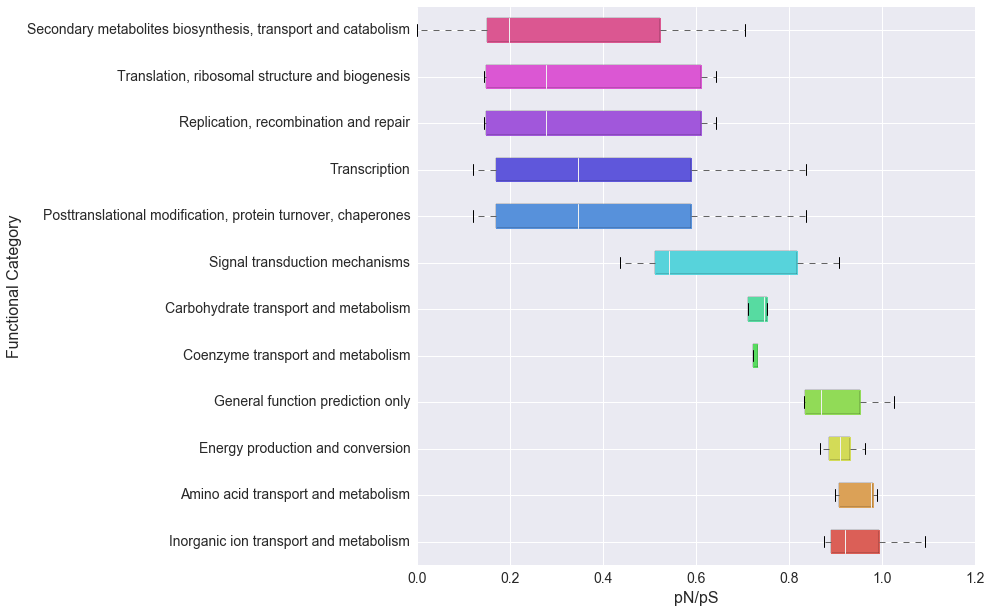

In [28]:
#sort the DataFrame to plot them by mean value
plot_order = eg_pnps.mean(axis=1).sort_values(inplace=False, ascending=False).index

fig, ax = mgkit.plots.get_single_figure(figsize=(10, 10))
_ = mgkit.plots.boxplot.boxplot_dataframe(
    eg_pnps, 
    plot_order, 
    ax, 
    fonts=dict(fontsize=14, rotation='horizontal'),
    data_colours={
        x: color
        for x, color in zip(plot_order, seaborn.color_palette('hls', len(eg_pnps.index)))
    },
    box_vert=False
)
_ = ax.set_xlabel('pN/pS', fontsize=16)
_ = ax.set_ylabel('Functional Category', fontsize=16)

#### Plot Distributions as KDE

Some better profiling can be found using the a KDE (Kernel Density Estimation). Seaborn makes it easy to plot it and it is easy to see that the Influent (first part) and Sludge digestion (last part) have a wider distribution of diversity estimates.

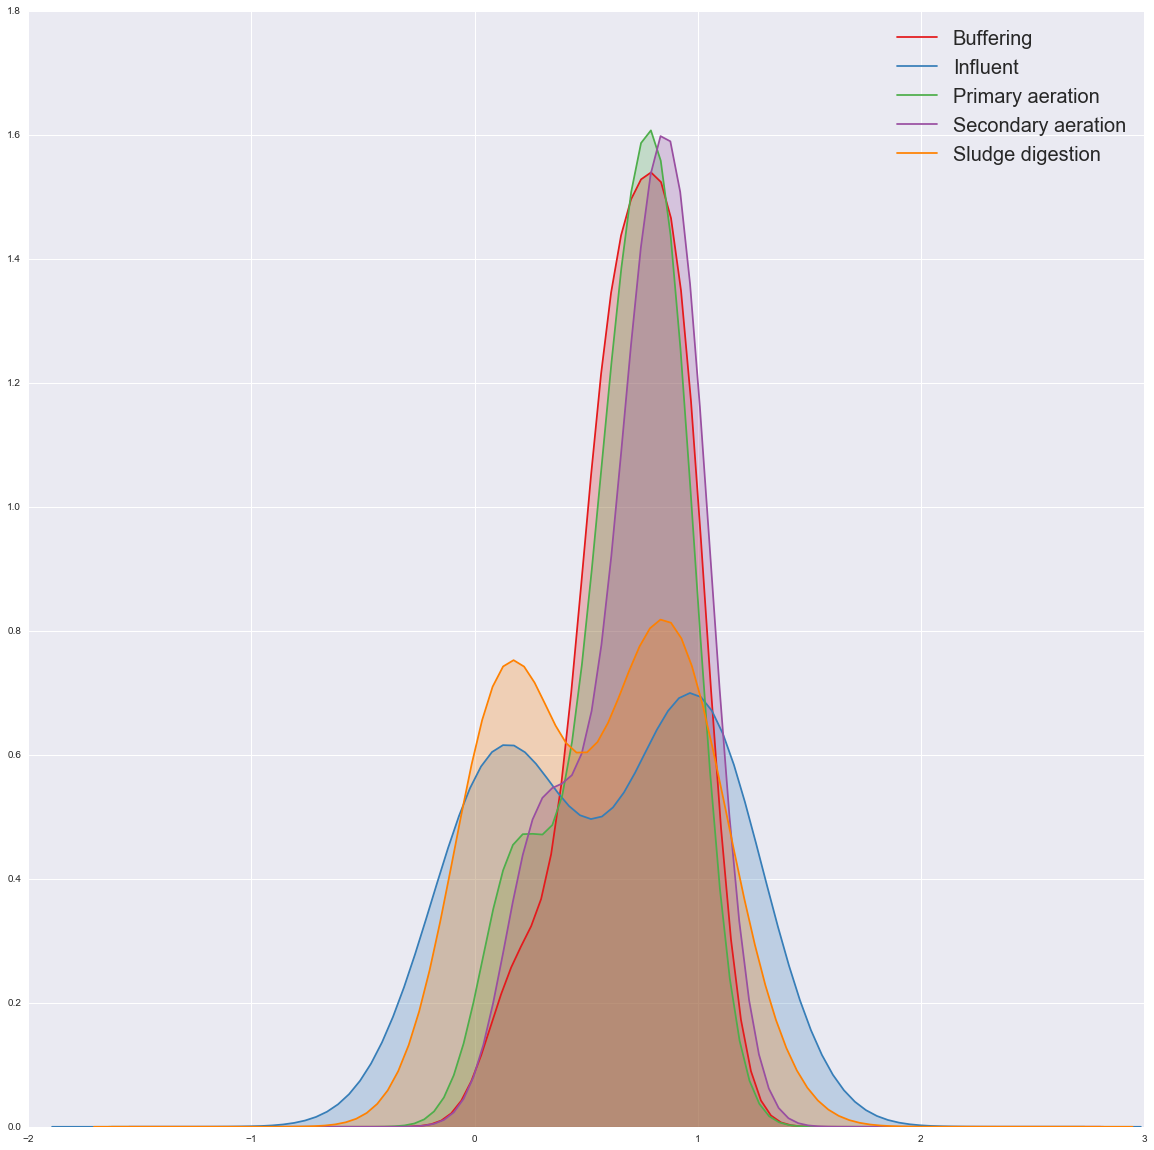

In [29]:
fig, ax = mgkit.plots.get_single_figure(figsize=(20, 20))

seaborn.set(font_scale=2)

for figid, (sample, color) in enumerate(zip(eg_pnps.columns, seaborn.color_palette('Set1', len(eg_pnps.columns)))):
    seaborn.kdeplot(eg_pnps[sample].dropna(), ax=ax, color=color, shade=True)

## Using Enzyme Classification

The enzyme classification mappings can be retrieved directly from KO identifiers using the Kegg REST API. MGKit provides a class that makes this easy to do.

In [30]:
# The first step is to instance the Kegg client class
kclient = mgkit.kegg.KeggClientRest()

In [31]:
# the *link_ids* is use to link any kind of identifiers within the Kegg DB. The first argument
# of the method is the target, in our case *ec*, for the enzyme classification and the second
# argument is the list of identifiers to map. To reduce the size of the query and because it would
# be redundant anyway, we can use a set for all annotations gene_id attribute we have.
ec_map = kclient.link_ids('ec', set(annotation.gene_id for annotation in annotations.itervalues()))

In [32]:
# You can see that for each KO identifier, a list of enzyme identifiers is returned
ec_map['K00260']

['1.4.1.2']

In [33]:
ec_pnps = mgkit.snps.get_gene_map_dataframe(snp_data, taxonomy, min_num=3, gene_map=ec_map, index_type='gene')

INFO:mgkit.snps.funcs:Analysing SNP from sample I
2015-12-04 14:11:47,538 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample I
INFO:mgkit.snps.funcs:Analysing SNP from sample SA
2015-12-04 14:11:47,663 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SA
INFO:mgkit.snps.funcs:Analysing SNP from sample B
2015-12-04 14:11:47,727 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample B
INFO:mgkit.snps.funcs:Analysing SNP from sample PA
2015-12-04 14:11:47,899 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample PA
INFO:mgkit.snps.funcs:Analysing SNP from sample SD
2015-12-04 14:11:48,116 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SD


In [34]:
# The enzyme classification naming is verbose, so it's better not to rename the rows
ec_pnps = ec_pnps.rename(columns=sample_names)

### Distributions of EC

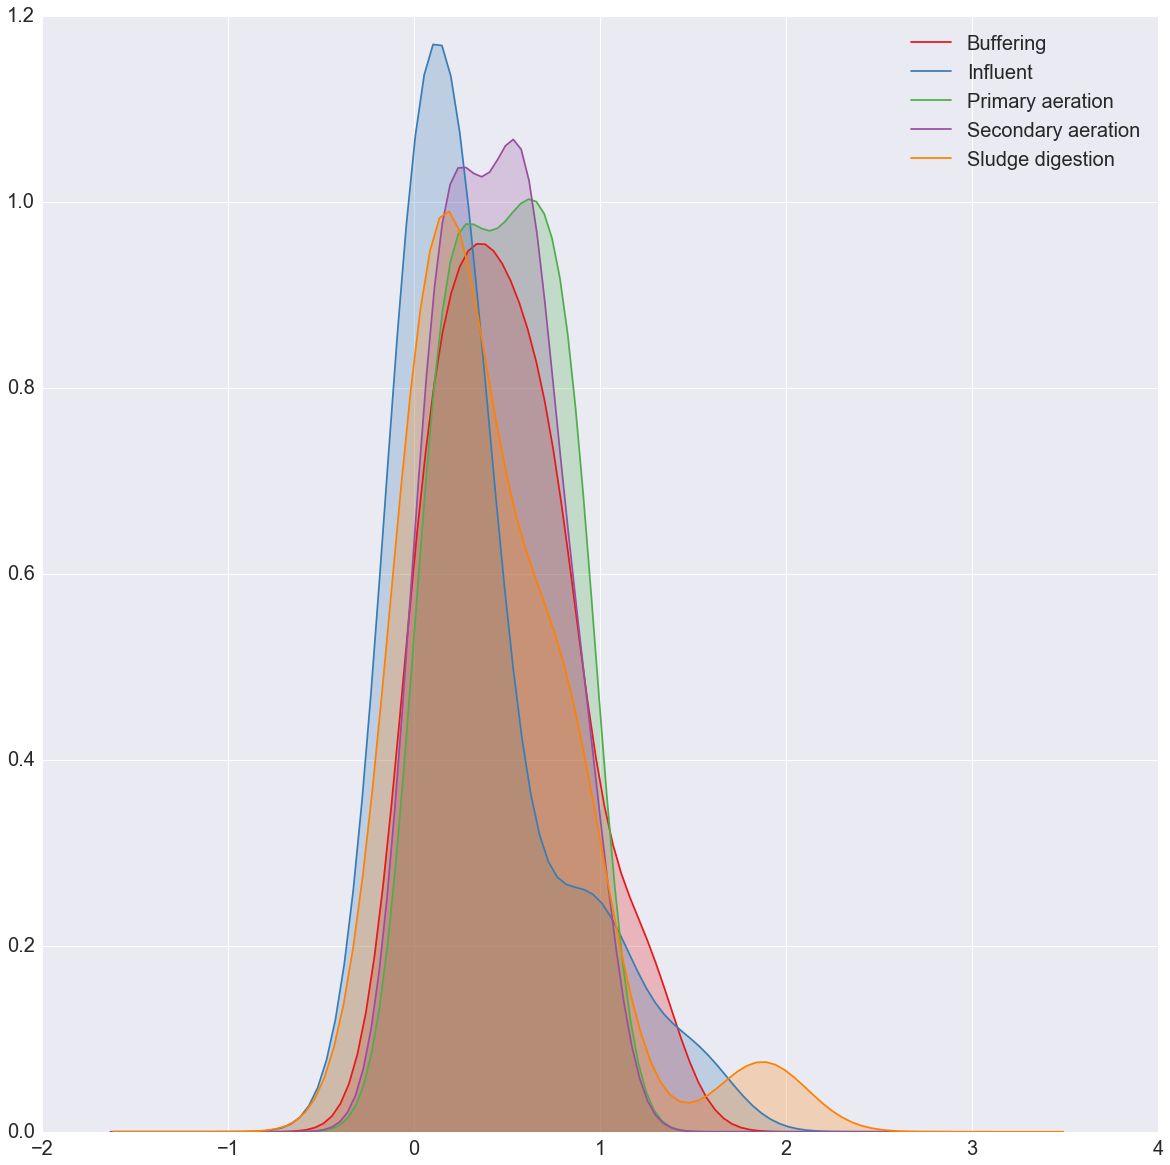

In [35]:
fig, ax = mgkit.plots.get_single_figure(figsize=(20, 20))

seaborn.set(font_scale=2)

for figid, (sample, color) in enumerate(zip(ec_pnps.columns, seaborn.color_palette('Set1', len(ec_pnps.columns)))):
    seaborn.kdeplot(ec_pnps[sample].dropna(), ax=ax, color=color, shade=True)

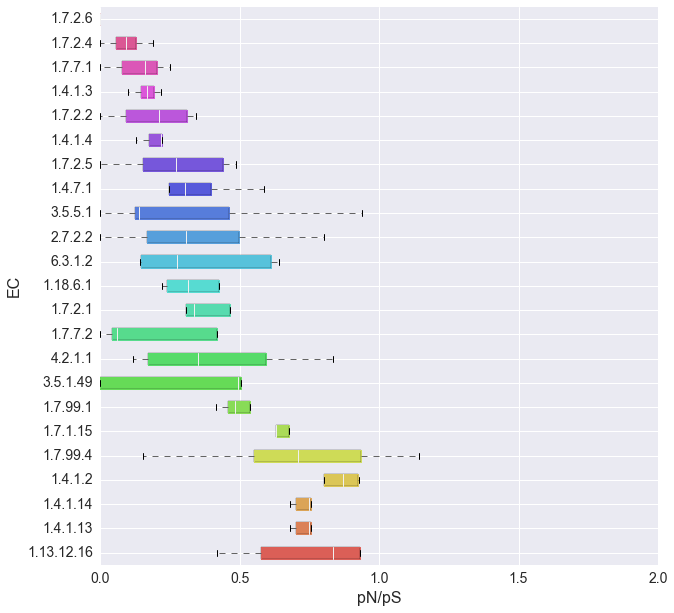

In [36]:
#sort the DataFrame to plot them by mean value
plot_order = ec_pnps.mean(axis=1).sort_values(inplace=False, ascending=False).index

fig, ax = mgkit.plots.get_single_figure(figsize=(10, 10))
_ = mgkit.plots.boxplot.boxplot_dataframe(
    ec_pnps, 
    plot_order, 
    ax, 
    fonts=dict(fontsize=14, rotation='horizontal'),
    data_colours={
        x: color
        for x, color in zip(plot_order, seaborn.color_palette('hls', len(ec_pnps.index)))
    },
    box_vert=False
)
_ = ax.set_xlabel('pN/pS', fontsize=16)
_ = ax.set_ylabel('EC', fontsize=16)

#### Adding full names to the enzymes

A dictionary with EC names (enzclass.txt) must be collected from expasy, at the following [address](ftp://ftp.expasy.org/databases/enzyme/enzclass.txt)

In [37]:
# The names of all EC identifiers can be obtained from expasy
ec_names = mgkit.mappings.enzyme.parse_expasy_file("{}map_data/enzclass.txt".format(data_dir))

In [38]:
reload(mgkit.mappings.enzyme)

<module 'mgkit.mappings.enzyme' from '/Users/francesco/dev/mgkit/mgkit/mappings/enzyme.pyc'>

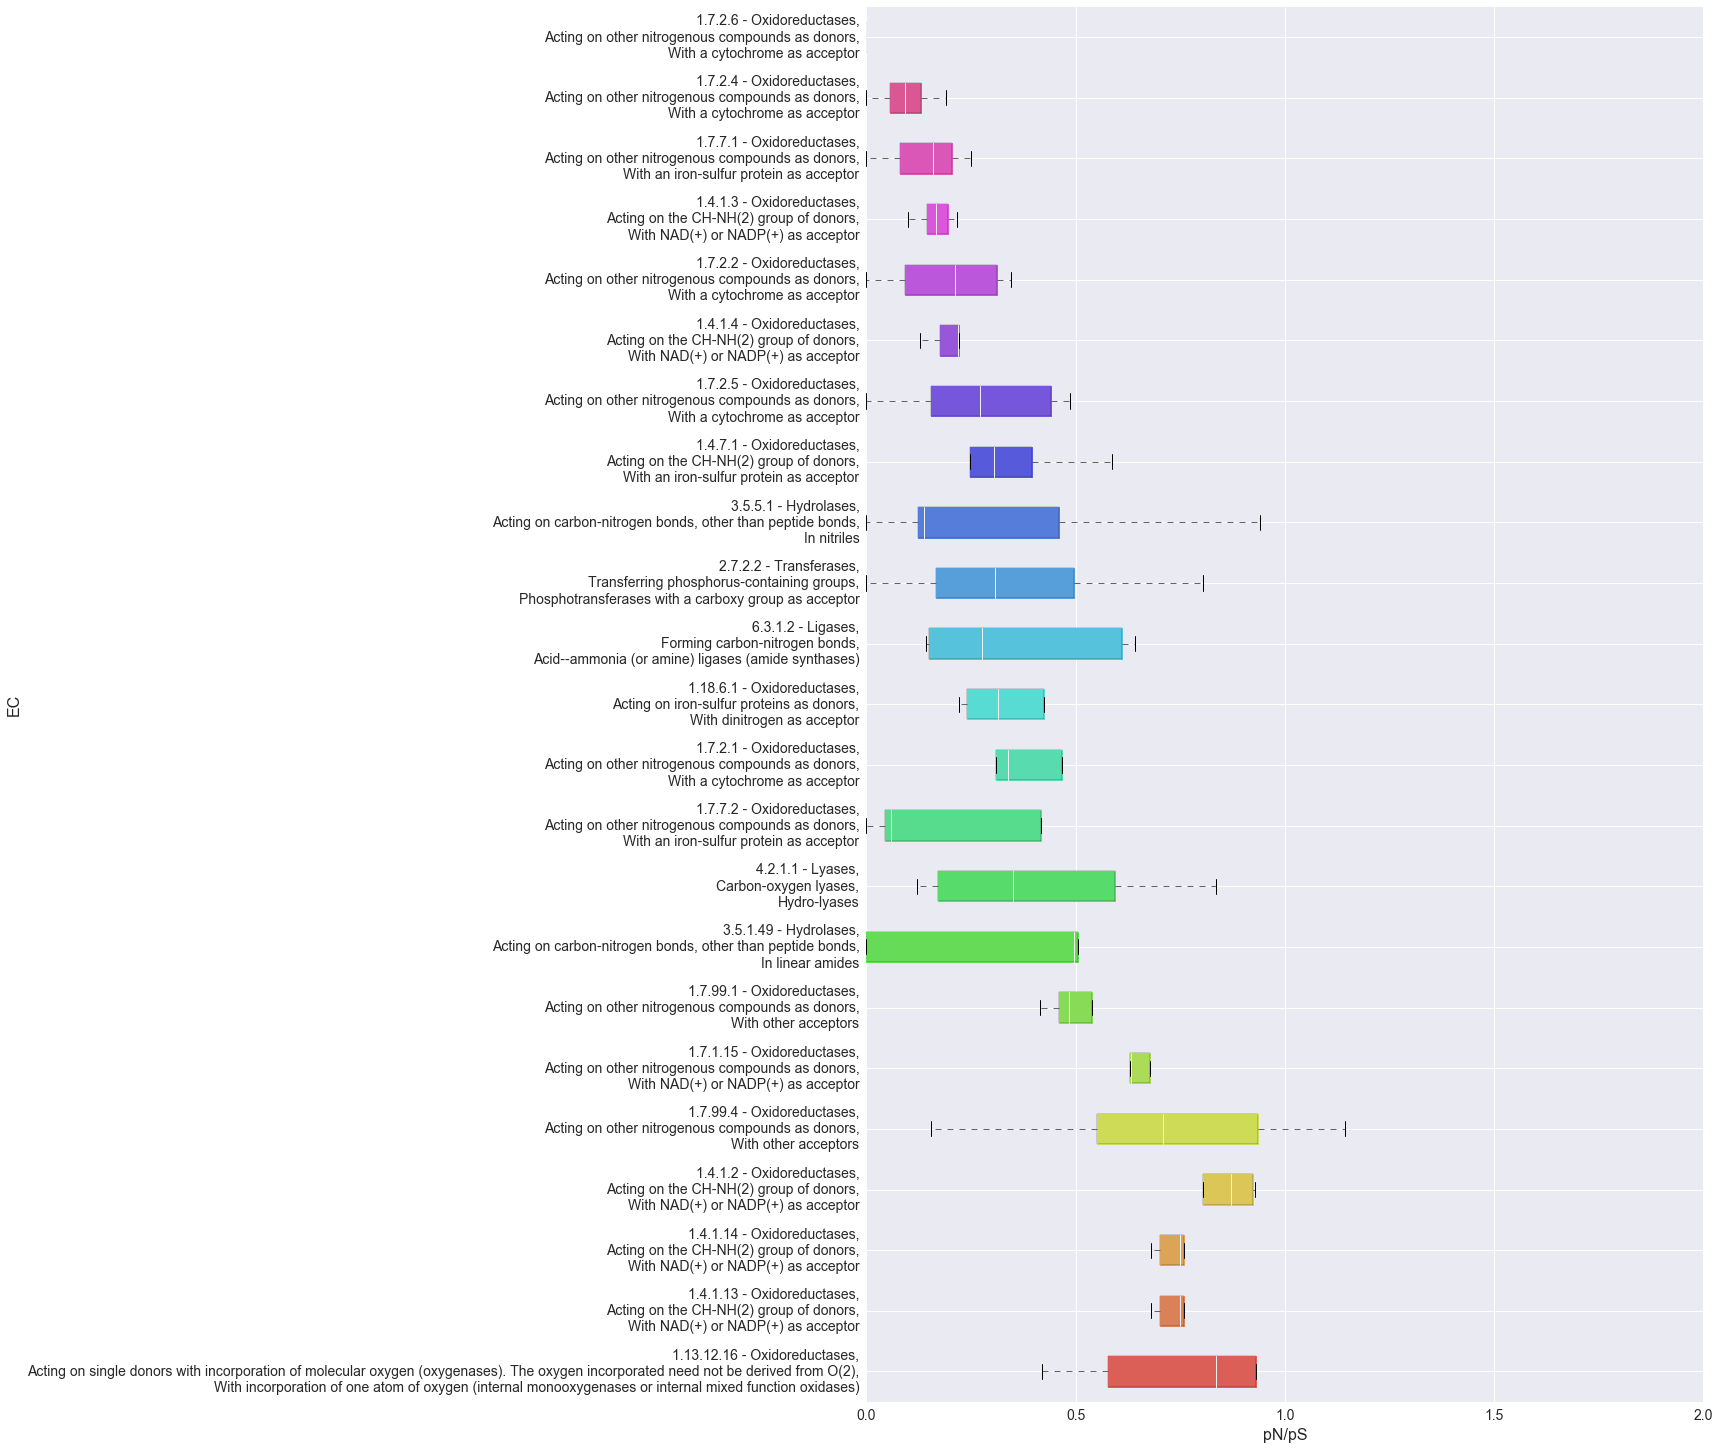

In [39]:
#sort the DataFrame to plot them by mean value
plot_order = ec_pnps.mean(axis=1).sort_values(inplace=False, ascending=False).index

fig, ax = mgkit.plots.get_single_figure(figsize=(15, 25))
_ = mgkit.plots.boxplot.boxplot_dataframe(
    ec_pnps, 
    plot_order,
    ax, 
    fonts=dict(fontsize=14, rotation='horizontal'),
    data_colours={
        x: color
        for x, color in zip(plot_order, seaborn.color_palette('hls', len(ec_pnps.index)))
    },
    box_vert=False,
    
    label_map={
        ec_id: "{} - {}".format(
            ec_id,
            mgkit.mappings.enzyme.get_enzyme_full_name(ec_id, ec_names, ',\n')
        )
        for ec_id in plot_order
    }
)
_ = ax.set_xlabel('pN/pS', fontsize=16)
_ = ax.set_ylabel('EC', fontsize=16)

## Using a Full Gene/Taxon DataFrame

It possible to use data at the most specific level, by using the **mgkit.snps.conv_func.get_full_dataframe** function.  This can be used to have a detail view of diversity in each taxon. In this tutorial, the gene will be from **Kegg  Ortholog**, while the most specific taxonomic level is the **Order**.

In our case, the output of the function will be a DataFrame with a *Multindex* for the *index*. This allows selective sorting, as it will be showed.

In [40]:
dataframe = mgkit.snps.conv_func.get_full_dataframe(snp_data, taxonomy)

INFO:mgkit.snps.funcs:Analysing SNP from sample I
2015-12-04 14:11:50,731 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample I
INFO:mgkit.snps.funcs:Analysing SNP from sample SA
2015-12-04 14:11:50,932 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SA
INFO:mgkit.snps.funcs:Analysing SNP from sample B
2015-12-04 14:11:51,005 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample B
INFO:mgkit.snps.funcs:Analysing SNP from sample PA
2015-12-04 14:11:51,138 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample PA
INFO:mgkit.snps.funcs:Analysing SNP from sample SD
2015-12-04 14:11:51,300 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SD


It's better not to rename the colummns/rows until the desired sorting is achieved
the sorting can not be possible if any duplicated key (gene, taxon) is found

In [41]:
# Change the sorting by taxon, gene
dataframe.reorder_levels(['taxon', 'gene']).sort_index()

B         I        PA        SA        SD
taxon   gene                                                    
29      K00261  0.000000  0.000000  0.000000  0.000000       NaN
        K00266  0.140967       NaN  0.053324  0.380403  0.000000
        K00363  0.303279       NaN  0.151639  0.606557       NaN
        K00370       NaN       NaN  0.000000  0.053983  0.000000
        K00372       NaN  0.000000       NaN  0.000000  0.146415
        K15578  0.291667  0.000000  0.170690  0.656191  0.418331
        K15579  0.000000       NaN  0.000000  0.000000       NaN
112     K00363       NaN  0.000000       NaN  0.000000  0.000000
        K15578  0.660185  0.640516  0.606150  0.653799       NaN
356     K00265  0.000000       NaN  0.000000  0.000000  0.000000
        K00362       NaN  0.000000  0.000000  0.000000  0.000000
        K00371  0.459016       NaN       NaN  0.000000  0.000000
        K00372       NaN  0.000000  0.000000  0.000000       NaN
        K00459       NaN  0.086168       NaN  0.000000  0.000000
        K02575  0.466768       NaN  1.238329  0.000000  1.234973
        K04561  0.406340       NaN  0.000000       NaN  0.348291
        K15577       NaN  0.000000  0.000000  0.000000  0.000000
        K15578  0.725553  0.884291  0.744028  0.729867  0.681625
1118    K00367  0.114286       NaN  0.114286       NaN  0.000000
        K15578  0.638354  1.200543  0.658668  0.876071  0.939685
        K15579  0.386453  0.970209  0.465236  0.658940  0.295370
1150    K01673  0.000000       NaN  0.000000       NaN  0.000000
        K15578       NaN  0.399038  0.000000  0.000000       NaN
1161    K15578       NaN  0.292953       NaN  0.116687  0.000000
        K15579  0.000000  0.125561  0.000000       NaN       NaN
1385    K00266  0.000000       NaN  0.000000       NaN  0.000000
        K00284  0.000000  0.000000  0.000000       NaN  0.000000
        K00362       NaN  6.823604  0.000000  0.000000  1.012594
        K00366  0.000000       NaN  0.000000  0.000000       NaN
        K00370  0.000000       NaN  0.000000  0.000000  0.000000
...                  ...       ...       ...       ...       ...
206389  K02567  1.544160       NaN  0.848485  0.000000  0.000000
        K02575  0.000000       NaN  0.000000  0.000000       NaN
        K15864  0.000000       NaN  0.142562  0.000000       NaN
213115  K00266  0.000000       NaN  0.000000       NaN  0.000000
        K01455  0.110273       NaN  0.055137  0.078766       NaN
213118  K00262  0.000000       NaN  0.000000  0.000000       NaN
        K00266  6.621481  0.451613  1.075269       NaN       NaN
213462  K00266       NaN       NaN  0.439230  0.000000  0.000000
213849  K00376       NaN  0.000000       NaN  0.000000  0.000000
        K15578  0.000000       NaN  0.000000  0.000000       NaN
225057  K00371  0.000000  0.000000  0.000000  0.000000  0.000000
        K00459       NaN  0.000000       NaN  0.000000  0.000000
307595  K00367  0.000000       NaN  0.000000       NaN  0.000000
        K15578  0.000000       NaN  0.000000       NaN  0.000000
485256  K01915  0.080504  0.000000       NaN  0.056889       NaN
693072  K00266  0.000000  0.086357  0.000000       NaN       NaN
713636  K00266       NaN       NaN  0.000000  0.000000  0.000000
        K02305  0.000000       NaN  0.000000  0.000000  0.000000
795748  K00261  0.045451       NaN  0.076788  0.000000  0.000000
        K00376  0.000000       NaN  0.000000  0.000000  0.000000
        K01915  0.061995  0.000000  0.078321  0.068932       NaN
909929  K01501  0.000000       NaN  0.000000  0.000000       NaN
1100069 K00376  0.000000       NaN  0.000000  0.000000  0.000000
1202465 K01915  0.041506  0.000000  0.119170       NaN       NaN
1240482 K01915  0.000000       NaN  0.000000       NaN  0.000000
1643683 K01915  0.000000       NaN  0.000000  0.000000       NaN
1643947 K00266  0.140845  0.095607  0.066368  0.147296  0.000000
1706369 K00266  0.000000  0.000000  0.000000  0.000000       NaN
        K00362  0.364706  0.145030       NaN  0.243137    

To get an idea of how many taxa the DataFrame has, we can use the following it will:

1. get all values for the **taxon** level
2. user the *unique* method of the index to deduplicate the values
3. check the length of the index

In [42]:
print(len(dataframe.index.get_level_values('taxon').unique()))

70


### Using EC to reduce the number of rows

One of the points here, is that we want to plot a diversity profile for each taxon that includes the boxplot for each of its genes. If we want to see all of them it will not be readable at all. Since it's too much data to visualise a good idea is taking hints of what seems to be important.

Reducing the complexity compromise the use of a mapping for both the genes *and* a different taxonomic *rank*. This allows to condense more information into a series of plots. It can be done using the **get_gene_taxon_dataframe** function and the following will make a EC/Phylum DataFrame.

In [43]:
dataframe = mgkit.snps.conv_func.get_gene_taxon_dataframe(snp_data, taxonomy, gene_map=ec_map, rank='phylum')

INFO:mgkit.snps.funcs:Analysing SNP from sample I
2015-12-04 14:11:51,454 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample I
INFO:mgkit.snps.funcs:Analysing SNP from sample SA
2015-12-04 14:11:51,533 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SA
INFO:mgkit.snps.funcs:Analysing SNP from sample B
2015-12-04 14:11:51,578 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample B
INFO:mgkit.snps.funcs:Analysing SNP from sample PA
2015-12-04 14:11:51,673 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample PA
INFO:mgkit.snps.funcs:Analysing SNP from sample SD
2015-12-04 14:11:51,788 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SD


In [44]:
print(len(dataframe.index.get_level_values('gene').unique()))

23


The number of plots is reduced and we can also reduce more by using a 3 level notation, instead of a 4 level one. One way to do this is using the already made *ec_map* and reducing the level of each enzyme associated with a KO identifier, using the **mgkit.mappings.enzyme.get_enzyme_level** function. This function accept a level (1 to 4), besides the EC identifier to change.

**Note:** take care to deduplicate the transformed EC identifiers, as they can change the diversity estimates.

In [45]:
ec3_map = {
    # a set can be created using all the EC identifiers from the ec_map dictionary
    ko_id: {mgkit.mappings.enzyme.get_enzyme_level(ec_id, 3) for ec_id in ec_ids}
    for ko_id, ec_ids in ec_map.iteritems()
}

In [46]:
# For comparison
print(ec3_map['K15864'], ec_map['K15864'])

set(['1.7.2', '1.7.99']) ['1.7.2.1', '1.7.99.1']


In [47]:
# The new DataFrame
dataframe = mgkit.snps.conv_func.get_gene_taxon_dataframe(snp_data, taxonomy, gene_map=ec3_map, rank='phylum')

INFO:mgkit.snps.funcs:Analysing SNP from sample I
2015-12-04 14:11:51,870 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample I
INFO:mgkit.snps.funcs:Analysing SNP from sample SA
2015-12-04 14:11:51,946 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SA
INFO:mgkit.snps.funcs:Analysing SNP from sample B
2015-12-04 14:11:51,994 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample B
INFO:mgkit.snps.funcs:Analysing SNP from sample PA
2015-12-04 14:11:52,104 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample PA
INFO:mgkit.snps.funcs:Analysing SNP from sample SD
2015-12-04 14:11:52,244 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SD


In [48]:
print(len(dataframe.index.get_level_values('gene').unique()))

13


As you can see, the number of genes was almost halved. It is a very specific level of functionality that can be undestood from this. The DataFrame can be plot on a 6x4 grid, using **mgkit.plots.get_grid_figure**, which internally uses the **GridSpec** class of matplotlib.

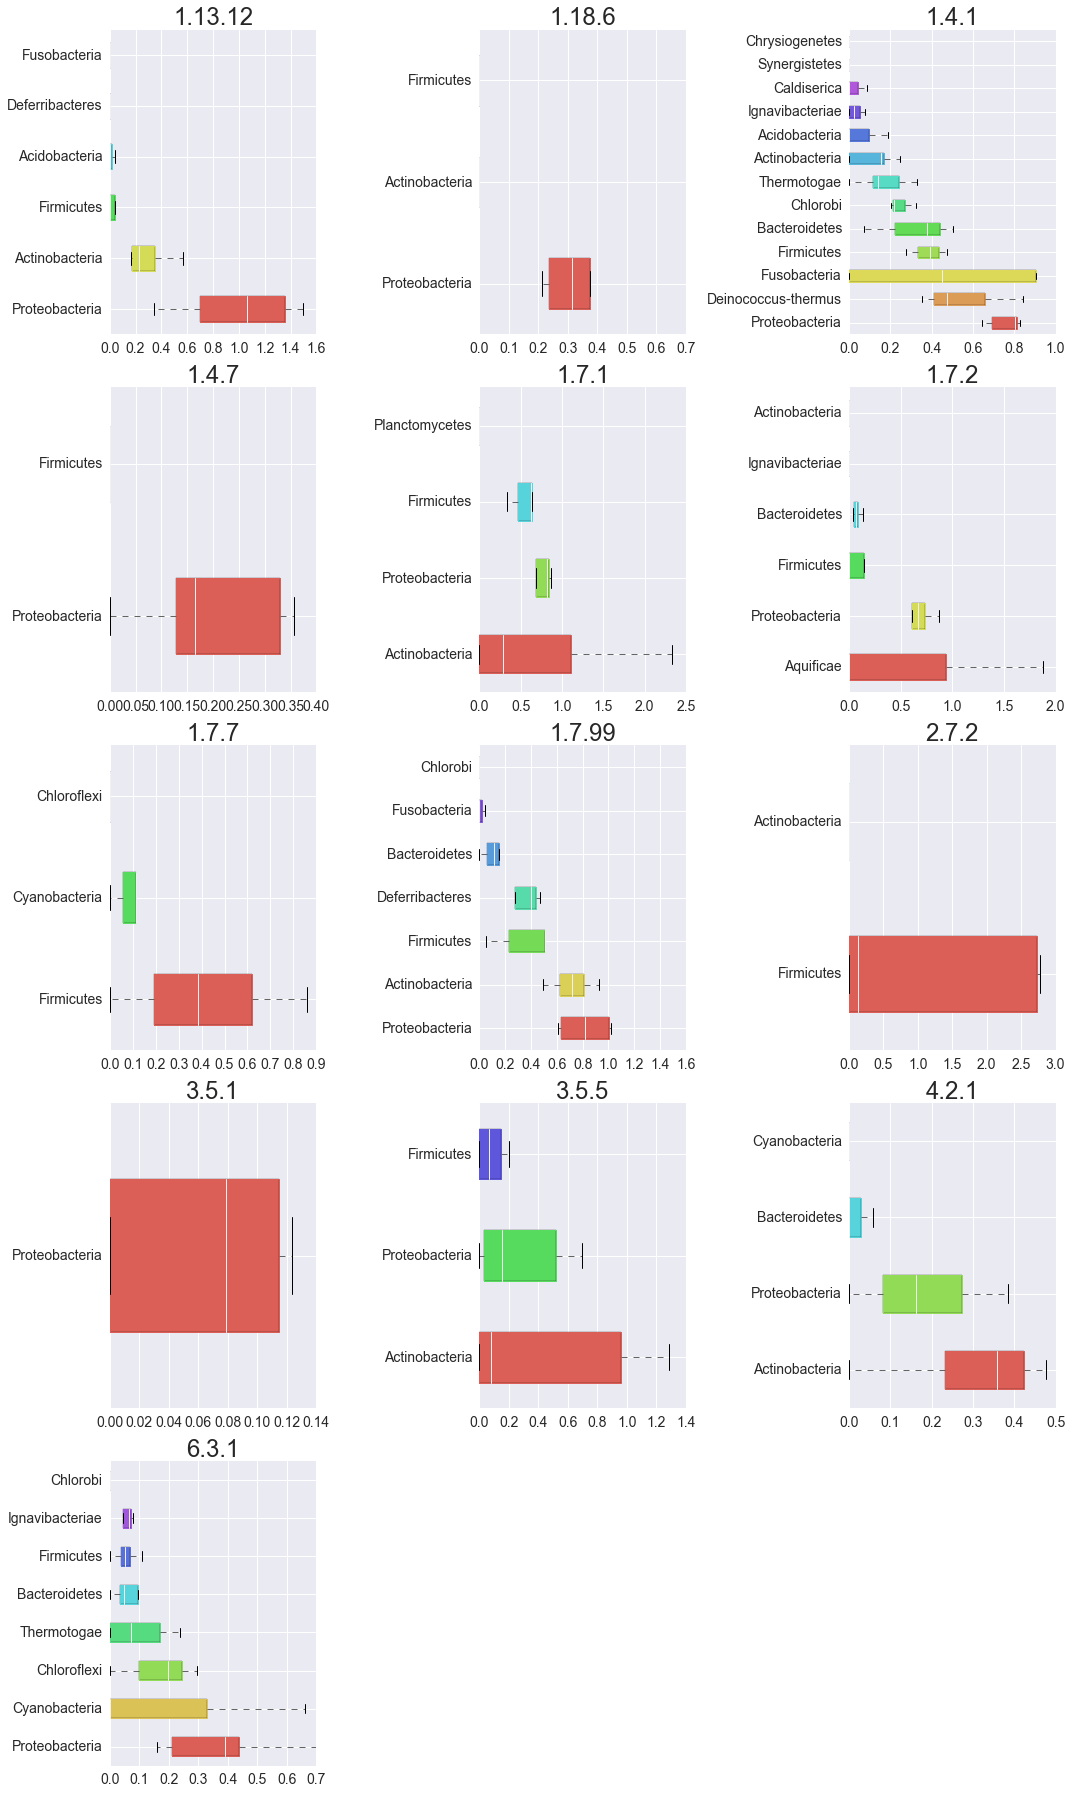

In [49]:
# As long as the multiplied numbers result in at least 13, the size of the plot
# can be customised
nrows = 5
ncols = 3

# the difference lies in the size of the grid we want to use and the return value
# that is a GridSpec instance
fig, gs = mgkit.plots.get_grid_figure(nrows, ncols, figsize=(5 * ncols, 5 * nrows))

for figid, ec_id in enumerate(sorted(dataframe.index.get_level_values('gene').unique())):
    # to create the axis for each it can either be used a gs[figid] to access in order the
    # block in the grid, or the notation gs[0, 1], to access the first row, second column
    # of the grid. It's easier to automate the process by using a single index notation,
    # so that's what we use in the example
    ax = fig.add_subplot(gs[figid])
    
    # we only plot one EC at a time
    ec_df = dataframe.loc[ec_id]
    
    #sort the DataFrame to plot them by mean value
    plot_order = ec_df.mean(axis=1).sort_values(inplace=False, ascending=False).index

    _ = mgkit.plots.boxplot.boxplot_dataframe(
        ec_df, 
        plot_order,
        ax, 
        fonts=dict(fontsize=14, rotation='horizontal'),
        data_colours={
            x: color
            for x, color in zip(plot_order, seaborn.color_palette('hls', len(ec_df.index)))
        },
        box_vert=False,
        label_map={x: taxonomy[x].s_name.capitalize() for x in plot_order}
    )
    _ = ax.set_title(ec_id)
fig.tight_layout()